In [ ]:
################################### Ensuring the notebook reloads modules automatically
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Imports + Load Dataset

In [ ]:
######### Import 3-party libraries #####################

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
# Feature Selection (Using SelectKBest to select top features based on correlation with the target)
from sklearn.feature_selection import SelectKBest, f_regression


### Learners
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor #ANN Variant
from sklearn.ensemble import BaggingRegressor   #for ANN-Bagging
from sklearn.ensemble import AdaBoostRegressor  #for ANN-AdaBoost

########################################################


In [ ]:
######################################################## Alternative Upload
from google.colab import files

### Upload the file manually
uploaded = files.upload()

### Load the uploaded file into a DataFrame
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)
print(df.head())

# Drop rows with NaN values
df_clean = df.dropna()
X = df_clean.drop(columns=['Bending Strength (MPa)','Modulus of Elasticity (MPa)','Failure Mode'])  # Replace 'target_variable' with your target column name

# Extract feature names before converting to NumPy [just in case]
feature_names = df_clean.columns[:-3]  # All columns except the last one (target)

WM = df_clean
#######################################################

Saving bamboo_data.csv to bamboo_data.csv
   Diameter (mm)  Wall Thickness (mm)  Linear Mass (kg/m)  Density (kg/m3)  \
0          88.00                 6.90                1.61           917.54   
1          94.25                 9.03                1.90           787.29   
2          97.25                 7.15                1.65           815.45   
3         103.00                 7.86                2.03           865.85   
4          96.50                 6.84                1.36           706.19   

   External Taper ( x 10-3)  Internal Taper ( x 10-3)  ISO Ovality  \
0                      5.67                      4.84         0.05   
1                      1.39                      1.20         0.01   
2                      5.40                      4.74         0.03   
3                      5.07                      3.91         0.01   
4                      4.38                      3.83         0.01   

   Eccentricity  Moisture Content (%)  Ultimate Force (N)  Moment (k

### Basic  Database Description

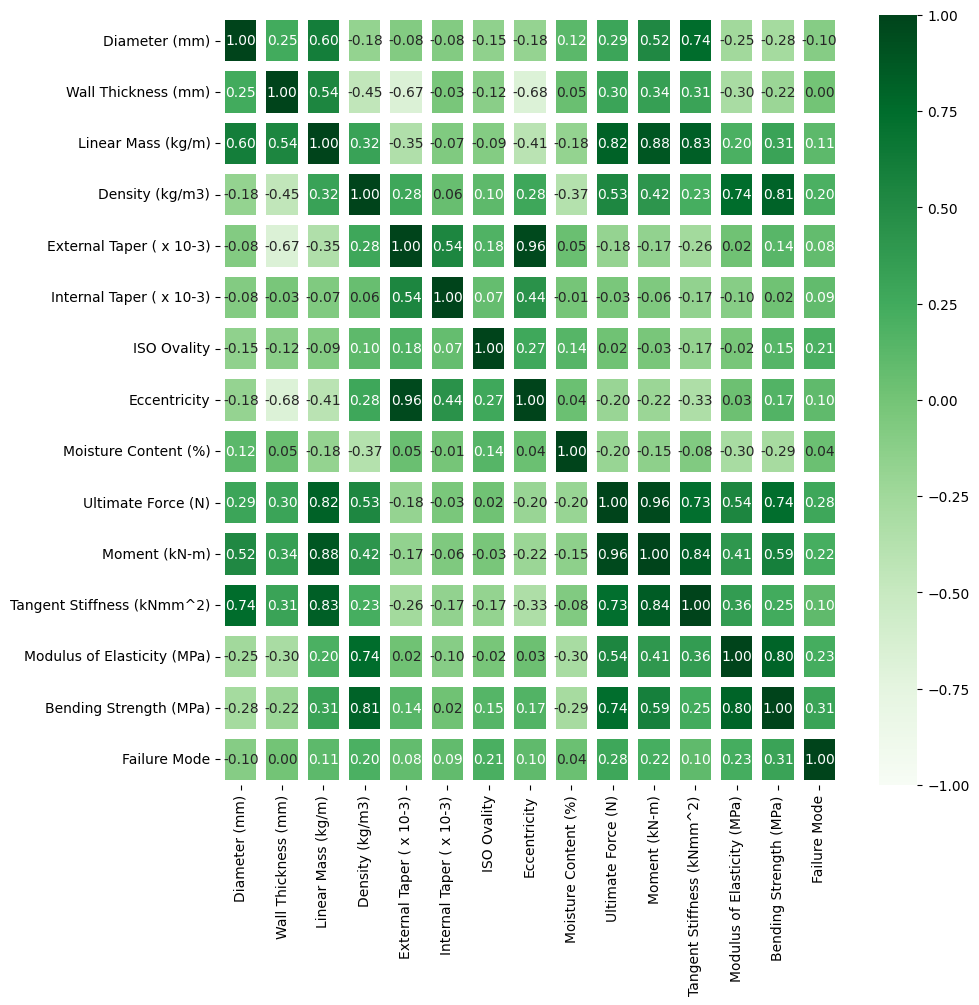

In [ ]:
######################################################## Visualize Correlation b/w features
### Let's make a Corre Heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(
    WM.corr(),
    cmap="Greens",
    annot=True,
    fmt='.2f',
    vmin=-1,
    vmax=+1,
    linewidths=6,
    linecolor='white',
    annot_kws={"size": 10}
)
plt.show()

In [ ]:
# Handling Missing Data: Drop rows with NaN values first, OR fill NaNs
df_clean = df.dropna()  # Drop rows with NaN values

# Alternatively, if you want to keep the rows but fill NaN values:
# df_clean = df.fillna(df.mean())  # Fill NaN with the mean of each column

## Preprocessing

In [ ]:
# Define the target columns
target_columns = ['Bending Strength (MPa)', 'Modulus of Elasticity (MPa)', 'Failure Mode']

# Define the feature columns (all columns except the target columns)
feature_columns = df_clean.columns.difference(target_columns)

# Extract features (X) and target (y)
X = df_clean[feature_columns].values
y = df_clean['Bending Strength (MPa)'].values  # Adjust this for your target

# Ensure no NaN values remain in X and y
print(f"Any NaNs in X? {np.isnan(X).any()}")
print(f"Any NaNs in y? {np.isnan(y).any()}")

Any NaNs in X? False
Any NaNs in y? False


In [ ]:
# Perform feature selection using SelectKBest
selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(X, y)

# Perform feature selection using SelectKBest
selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(X, y)

# If needed, fill NaNs in X_selected
X_selected = pd.DataFrame(X_selected).fillna(X_selected.mean())

In [ ]:
# Check again if NaNs are gone
print(f"Any NaNs in X_selected after imputation? {np.isnan(X_selected).any()}")
print(f"Any NaNs in y after imputation? {np.isnan(y).any()}")

Any NaNs in X_selected after imputation? 0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
dtype: bool
Any NaNs in y after imputation? False


## Training 1: MLPRegressor
MLPRegressor is a type of artificial neural network (ANN). Specifically, it is a Multi-Layer Perceptron (MLP) used for regression tasks.  
This is the ANN standalone model of the study.

In [ ]:
# Setting a random seed for reproducibility
random_seed = 0
np.random.seed(random_seed)

In [ ]:
# Ensure that X_selected is a NumPy array
X_selected_np = X_selected.to_numpy() if isinstance(X_selected, pd.DataFrame) else X_selected

# Custom RMSE function
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Improved MAPE to handle zero values in y_true
def mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-10):
    y_true = np.where(y_true == 0, epsilon, y_true)  # Avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to evaluate model using K-Fold Cross-Validation
def evaluate_best_model_with_cv(best_model, X, y, n_splits=5):
    # Ensure X is a NumPy array
    X = X.to_numpy() if isinstance(X, pd.DataFrame) else X

    # Define scoring metrics
    scoring = {
        'R2': make_scorer(r2_score),
        'RMSE': make_scorer(root_mean_squared_error),
        'MAE': make_scorer(mean_absolute_error),
        'MAPE': make_scorer(mean_absolute_percentage_error)
    }

    # Define K-Fold cross-validation
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

    # Initialize dictionary to store scores
    scores = {metric: [] for metric in scoring}  # Store per-fold scores

    for train_idx, val_idx in cv.split(X):
      X_train, X_val = X[train_idx], X[val_idx]
      y_train, y_val = y[train_idx], y[val_idx]

     # Perform feature selection on training data
      selector = SelectKBest(score_func=f_regression, k=10)
      X_train_selected = selector.fit_transform(X_train, y_train)
      X_val_selected = selector.transform(X_val)  # Apply the same transformation to validation data

      # Fit the best model to the training data
      best_model.fit(X_train_selected, y_train)

      # Predict on validation set
      y_val_pred = best_model.predict(X_val_selected)


      # Calculate scores for each metric
      for metric_name, scorer in scoring.items():
          if metric_name == 'R2':
              score = r2_score(y_val, y_val_pred)
          elif metric_name == 'RMSE':
              score = root_mean_squared_error(y_val, y_val_pred)
          elif metric_name == 'MAE':
              score = mean_absolute_error(y_val, y_val_pred)
          elif metric_name == 'MAPE':
              score = mean_absolute_percentage_error(y_val, y_val_pred)

          scores[metric_name].append(score)

    # Calculate mean and standard deviation of scores for each metric
    mean_scores = {metric: np.mean(scores[metric]) for metric in scores}
    std_scores = {metric: np.std(scores[metric]) for metric in scores}

    # Print results
    print("Cross-Validation Results for Best Model:")
    for metric in mean_scores:
        print(f"{metric}: Mean = {mean_scores[metric]:.4f}, Std = {std_scores[metric]:.4f}")

    return scores, mean_scores, std_scores  # Returning the correct scores dictionary

In [ ]:
# Hyperparameter grid for tuning
param_dist = {
    'model__hidden_layer_sizes': [(20,), (50,), (100,), (20, 20), (50, 50), (100, 100), (150,), (200,), (50, 50, 50)],
    'model__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'model__solver': ['lbfgs', 'sgd', 'adam'],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'model__batch_size': [32, 64, 128],  # Added batch_size for better control over updates
    'model__max_iter': [1000, 2000, 3000],  # Add more options for iterations
    'model__early_stopping': [True, False],  # Include early stopping option
}

# Set up the pipeline with scaling
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # You can switch to RobustScaler if needed
    ('model', MLPRegressor(random_state=random_seed, max_iter=10000))  # Set random_state for reproducibility
])

# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=50,  # Number of random parameter combinations to try
    cv=5,  # 5-fold cross-validation
    random_state=random_seed,
    scoring='r2',  # Optimize based on R² score
    n_jobs=-1,  # Use all available processors
    error_score='raise',  # Raise an error if a fit fails, for easier debugging
    verbose=2  # Show detailed output during the search
)

# Train the model using RandomizedSearchCV
try:
    random_search.fit(X_selected_np, y)
except ValueError as e:
    print(f"Error during RandomizedSearchCV: {e}")

# Output the best hyperparameters
if hasattr(random_search, 'best_params_'):
    best_params = random_search.best_params_
    print(f"Best Hyperparameters: {best_params}")

# Optionally, print the best model as well
if hasattr(random_search, 'best_estimator_'):
    best_estimator = random_search.best_estimator_
    print(f"Best Model: {best_estimator}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'model__solver': 'lbfgs', 'model__max_iter': 1000, 'model__learning_rate': 'constant', 'model__hidden_layer_sizes': (200,), 'model__early_stopping': True, 'model__batch_size': 32, 'model__alpha': 0.001, 'model__activation': 'logistic'}
Best Model: Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 MLPRegressor(activation='logistic', alpha=0.001, batch_size=32,
                              early_stopping=True, hidden_layer_sizes=(200,),
                              max_iter=1000, random_state=0, solver='lbfgs'))])


In [ ]:
# Function to compute 95% confidence intervals
def compute_confidence_intervals(scores):
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    # 95% Confidence Interval
    ci_lower = mean_score - 1.96 * std_score / np.sqrt(len(scores))
    ci_upper = mean_score + 1.96 * std_score / np.sqrt(len(scores))
    return mean_score, ci_lower, ci_upper

# Visualization of per-fold cross-validation scores
def plot_cv_scores(scores_per_fold):
    metrics = ['R2', 'RMSE', 'MAE', 'MAPE']
    n_folds = len(scores_per_fold['R2'])

    # Create a subplot for each metric
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.ravel()  # Flatten the axis array for easier access

    for i, metric in enumerate(metrics):
        fold_scores = scores_per_fold[metric]
        axs[i].bar(range(1, n_folds+1), fold_scores, color='skyblue')
        axs[i].set_title(f'CV {metric} Scores per Fold')
        axs[i].set_xlabel('Fold Number')
        axs[i].set_ylabel(metric)
        axs[i].set_xticks(range(1, n_folds+1))

    plt.tight_layout()
    plt.show()

# Plot mean CV scores with confidence intervals
def plot_mean_scores_with_ci(mean_scores, ci_scores):
    metrics = ['R2', 'RMSE', 'MAE', 'MAPE']
    mean_vals = [mean_scores[metric] for metric in metrics]
    ci_lowers = [ci_scores[metric][0] for metric in metrics]
    ci_uppers = [ci_scores[metric][1] for metric in metrics]

    # Bar plot for mean values with error bars for confidence intervals
    plt.figure(figsize=(10, 6))
    plt.bar(metrics, mean_vals, yerr=[np.abs(np.array(ci_lowers) - np.array(mean_vals)),
                                      np.abs(np.array(ci_uppers) - np.array(mean_vals))],
            capsize=10, color='lightblue', edgecolor='black')
    plt.title('Mean CV Evaluation Metrics with 95% Confidence Intervals')
    plt.ylabel('Score')
    plt.show()

Cross-Validation Results for Best Model:
R2: Mean = 0.9977, Std = 0.0015
RMSE: Mean = 0.9865, Std = 0.3042
MAE: Mean = 0.7255, Std = 0.1892
MAPE: Mean = 0.9292, Std = 0.2678


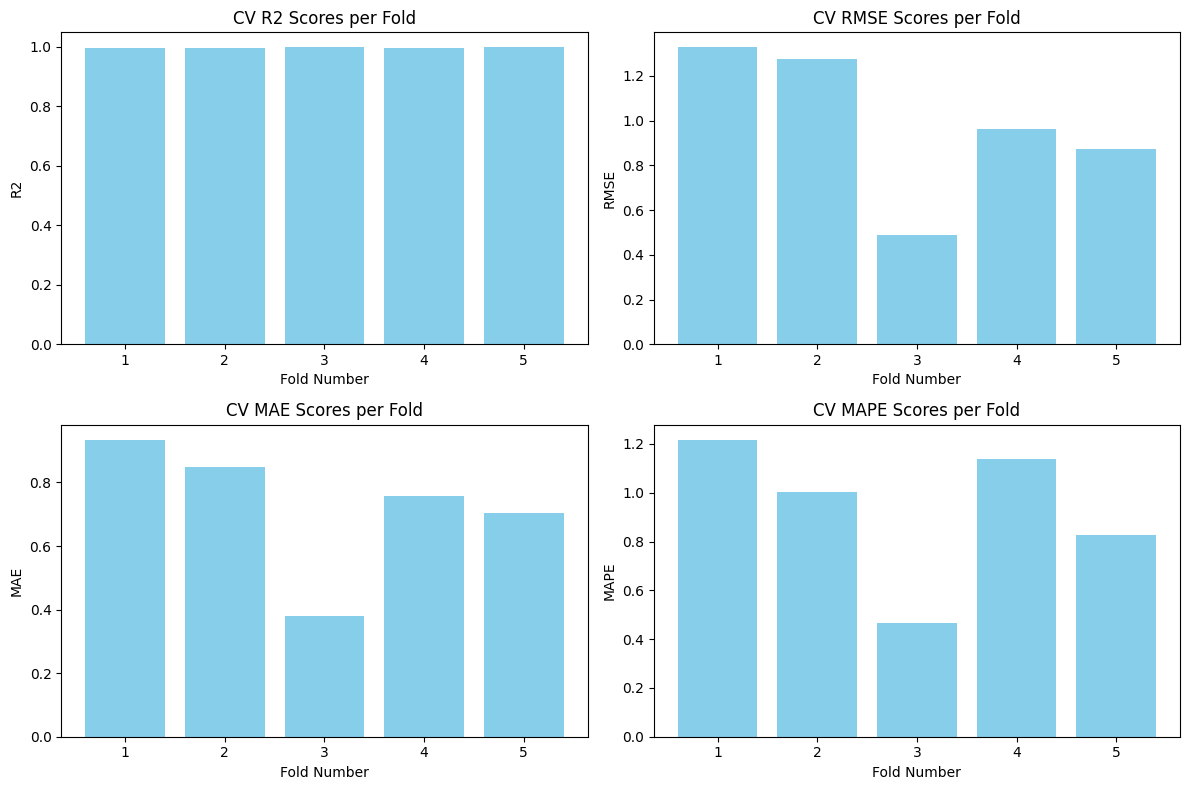

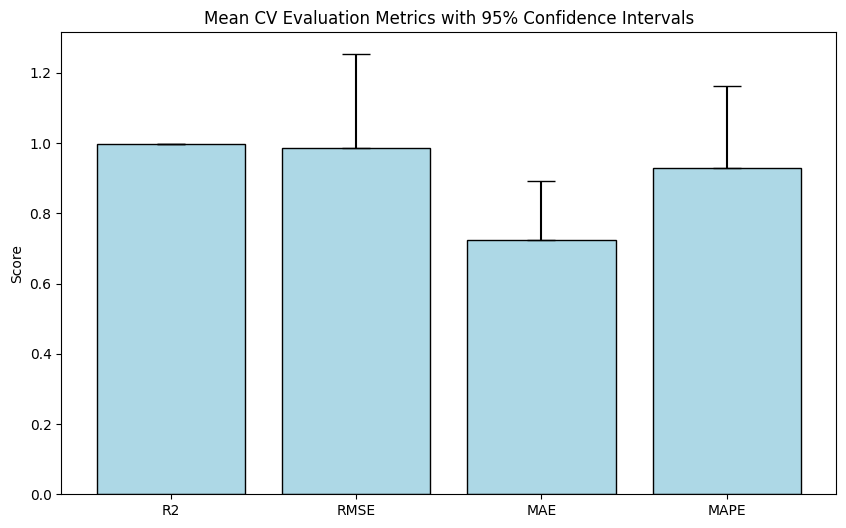

In [ ]:
# Assuming the function 'evaluate_best_model_with_cv' returns scores_per_fold:
if hasattr(random_search, 'best_estimator_'):
    scores_per_fold, mean_scores, std_scores = evaluate_best_model_with_cv(random_search.best_estimator_, X_selected_np, y, n_splits=5)

# Plot the per-fold cross-validation scores
plot_cv_scores(scores_per_fold)

# Compute mean and confidence intervals for each metric
mean_scores_ci = {}
for metric, scores in scores_per_fold.items():
    mean_scores_ci[metric] = compute_confidence_intervals(scores)

# Plot mean scores with confidence intervals
plot_mean_scores_with_ci(mean_scores, mean_scores_ci)


In [ ]:
# Ensure X_selected_np and y are defined and prepared earlier in your code

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_selected_np, y, test_size=0.2, random_state=random_seed)

# Fit the best model from RandomizedSearchCV to the training data
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred_test = best_model.predict(X_test)


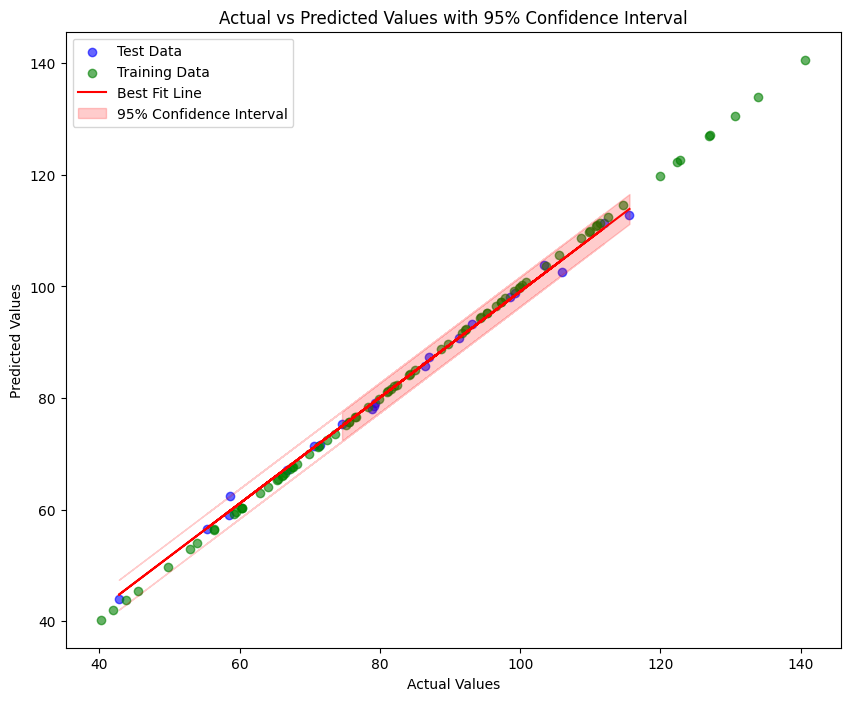

In [ ]:
# Scatter plot of actual vs predicted values for the testing set
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_test, color='blue', label='Test Data', alpha=0.6)

# Optionally, add the training data to the plot for comparison
y_pred_train = best_model.predict(X_train)
plt.scatter(y_train, y_pred_train, color='green', label='Training Data', alpha=0.6)

# Fit a line of best fit (linear regression)
fit_line = np.poly1d(np.polyfit(y_test, y_pred_test, 1))
plt.plot(y_test, fit_line(y_test), color='red', label='Best Fit Line')

# Calculate mean squared error for confidence intervals
mse = mean_squared_error(y_test, y_pred_test)
stdev = np.sqrt(mse)

# Calculate confidence intervals (mean prediction +/- 1.96 * stdev for 95% confidence interval)
ci_upper = fit_line(y_test) + 1.96 * stdev
ci_lower = fit_line(y_test) - 1.96 * stdev

# Shade the confidence interval
plt.fill_between(y_test, ci_lower, ci_upper, color='red', alpha=0.2, label='95% Confidence Interval')

# Labels and legend
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values with 95% Confidence Interval')
plt.legend()

# Show the plot
plt.show()


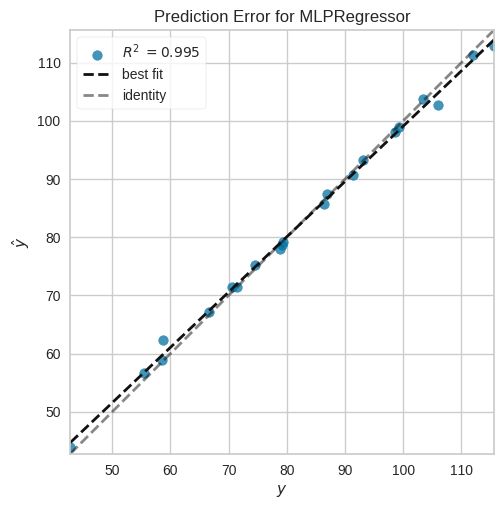

<Axes: title={'center': 'Prediction Error for MLPRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [ ]:
from yellowbrick.regressor import PredictionError

# Create the visualization object for SVR on training data
visualizer = PredictionError(best_model)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()

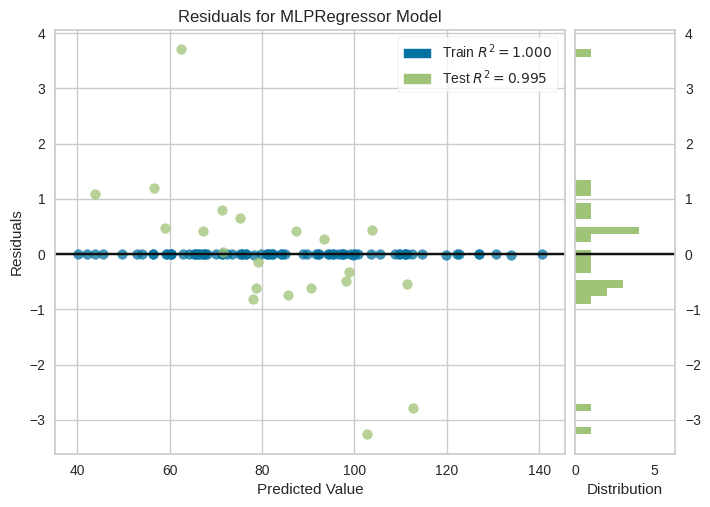

<Axes: title={'center': 'Residuals for MLPRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [ ]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(best_model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test,y_test)
visualizer.poof()

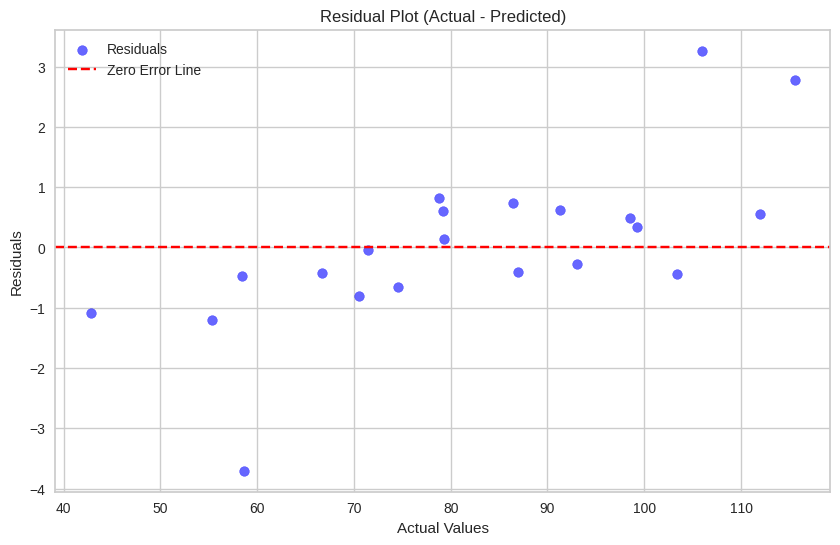

In [ ]:
# Calculate residuals
residuals = y_test - y_pred_test

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='blue', label='Residuals', alpha=0.6)
plt.axhline(0, color='red', linestyle='--', label='Zero Error Line')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Actual - Predicted)')
plt.legend()
plt.show()


## Parameter Tuning

## Parameters & Model to use

In [ ]:
# Learning Curves
def plot_learning_curve(model, X, y, cv=5):
    # Generate learning curves
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # Calculate mean and std of train and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)

    train_scores_std = np.std(train_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Score', color="blue")
    plt.plot(train_sizes, val_scores_mean, 'o-', label='Validation Score', color="green")

    # Fill between for confidence interval (std deviation)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="blue")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color="green")

    plt.title('Learning Curve for MLPRegressor')
    plt.xlabel('Training Set Size')
    plt.ylabel('R² Score')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

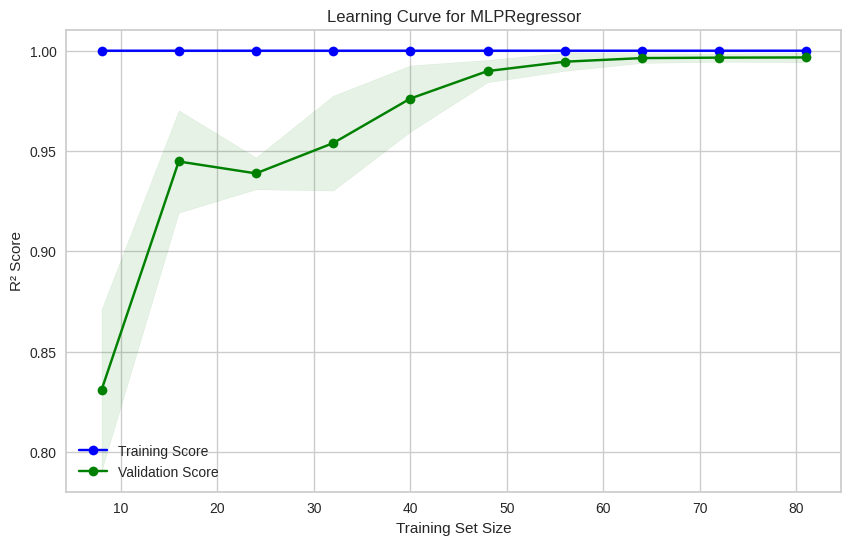

In [ ]:
# Plot learning curve for the tuned MLP model
# Using the best_model found through RandomizedSearchCV
plot_learning_curve(best_model, X_selected_np, y)

# **SHAP ANALYSIS**  

In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 33.2 MB/s eta 0:00:00


## SHAP for Best Model Used  
Two Explainers that can be used for ANNs: KernelExplainer and PermutationExplainer

In [ ]:
#########################################################
# SHAP analysis using KernelExplainer
import shap
import matplotlib.pyplot as plt

# SHAP expects the model to be callable, so we need to pass the model pipeline including the scaler
explainer = shap.KernelExplainer(best_model.predict, X_train)
# Generate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
# Assuming you already have your original list of feature columns
original_feature_columns = df.columns.difference(target_columns)

# Get the mask of the selected features (True for selected, False otherwise)
selected_feature_mask = selector.get_support()

# Filter the original feature columns based on the selected features
selected_feature_columns = np.array(original_feature_columns)[selected_feature_mask]

# Now you can use selected_feature_columns for SHAP plotting


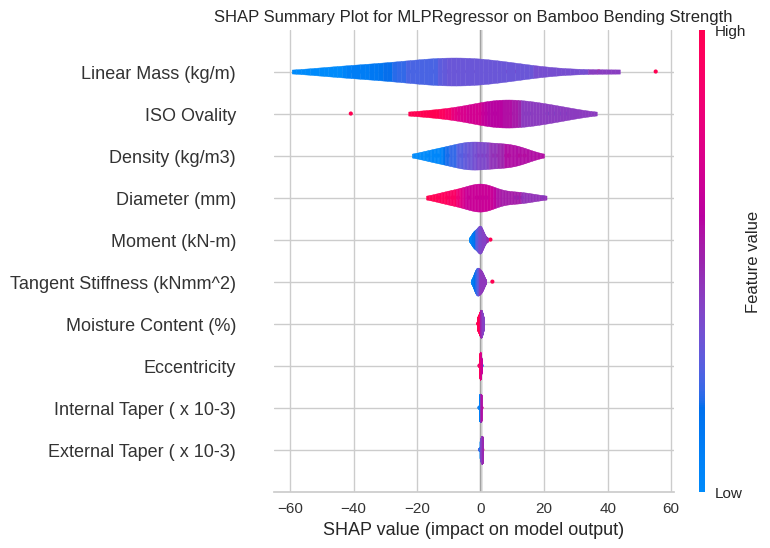

In [ ]:
###################################################################
# Global summary plot for all instances in the test set
shap.summary_plot(shap_values, X_test, feature_names=feature_columns, show=False, plot_type='violin')
plt.title(f'SHAP Summary Plot for MLPRegressor on Bamboo Bending Strength')
plt.show()


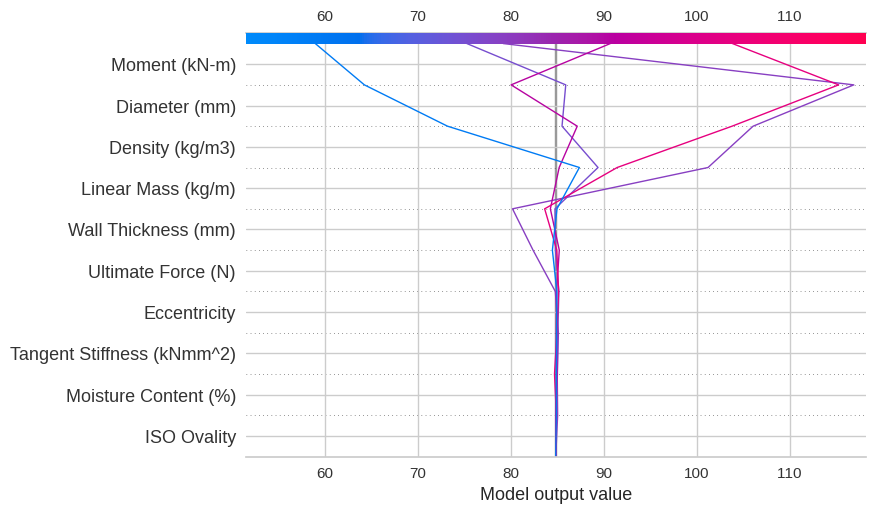

In [ ]:
# Decision plot for multiple instances
expected_value = explainer.expected_value
shap.decision_plot(expected_value, shap_values[:5], X_test[:5], feature_names=selected_feature_columns)


In [ ]:
# Optional: Extract SHAP values for each feature and instance
# shap_values[:5] contains the SHAP values for the first 5 instances.
# You can convert them into a DataFrame for better readability.

# Create a DataFrame with SHAP values for the first 5 instances
shap_values_df = pd.DataFrame(shap_values[:5], columns=selected_feature_columns)

# Print the SHAP values for each feature
print("SHAP values for the first 5 instances:")
print(shap_values_df)

# Optional: If you want to see how much each feature contributes to the final model output for each instance
# You can sum these SHAP values for each instance to see how close they are to the predicted output (expected_value + shap_value contributions)
for i in range(5):
    print(f"\nInstance {i+1} - Prediction Contribution Breakdown:")
    for feature, value in zip(selected_feature_columns, shap_values[i]):
        print(f"{feature}: {value:.3f}")

    # You can also print the predicted output for comparison
    print(f"Predicted output for Instance {i+1}: {expected_value + sum(shap_values[i]):.3f}")


SHAP values for the first 5 instances:
   Density (kg/m3)  Diameter (mm)  Eccentricity  ISO Ovality  \
0        -3.871687       0.400384      0.117133     0.067467   
1         4.845728      10.829931     -0.330670     0.205507   
2         1.943119      -7.111673      0.022760     0.009012   
3        12.357202      11.463087      0.183051     0.070913   
4       -14.184831      -8.939071      0.027532     0.061540   

   Linear Mass (kg/m)  Moisture Content (%)  Moment (kN-m)  \
0            4.627756              0.112129     -10.634413   
1           21.026370             -0.042213     -37.703665   
2            0.948573              0.112149      10.668955   
3            7.798542             -0.200363     -11.420308   
4            2.410577             -0.004426      -5.276028   

   Tangent Stiffness (kNmm^2)  Ultimate Force (N)  Wall Thickness (mm)  
0                    0.042348           -0.370143            -0.047544  
1                    0.123816           -2.395722        

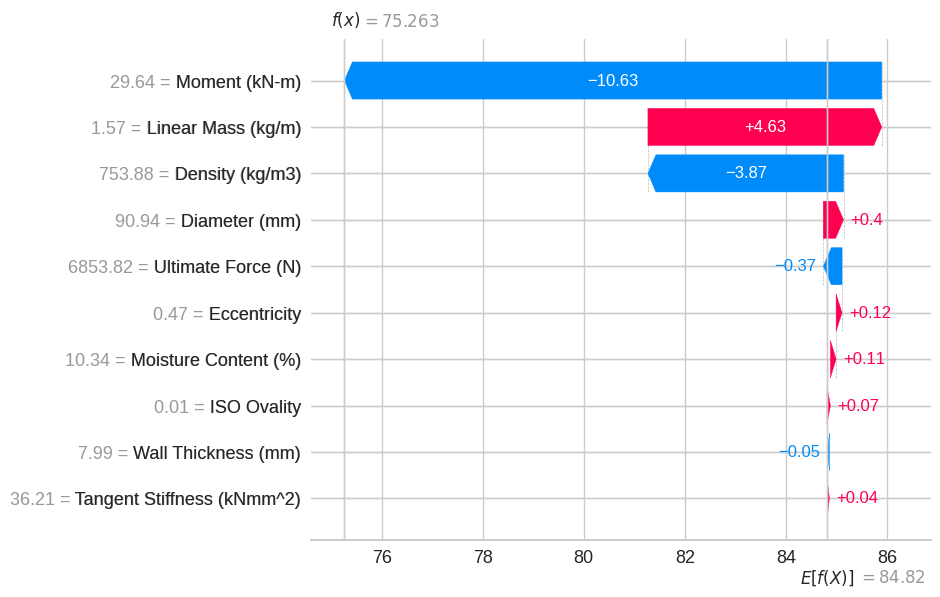

In [ ]:
import shap

#he SHAP values for the first instance in X_test

# Create a SHAP values object that contains both SHAP values and feature names
shap_values_instance = shap.Explanation(values=shap_values[0],
                                        base_values=explainer.expected_value,
                                        data=X_test[0],
                                        feature_names=selected_feature_columns)

# Plot the waterfall plot for the first instance
shap.waterfall_plot(shap_values_instance)
